<a href="https://colab.research.google.com/github/saikola2004/fmml_22B214551/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [ ]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2024-02-23 14:23:13--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   731KB/s    in 1.3s    

2024-02-23 14:23:17 (731 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [ ]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [ ]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [ ]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


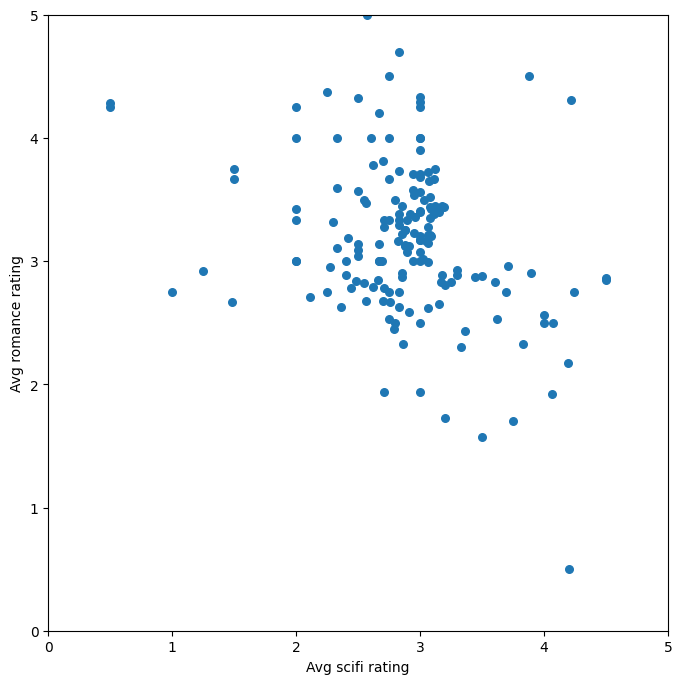

In [ ]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


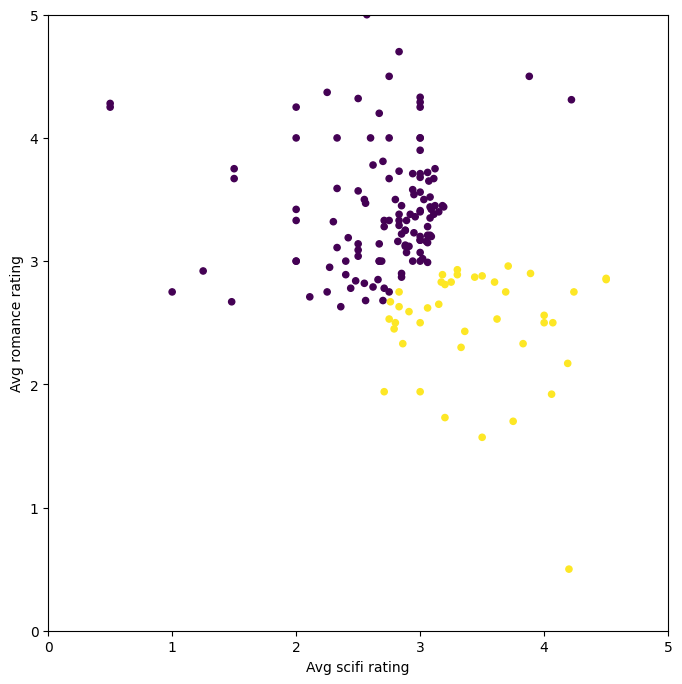

In [ ]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


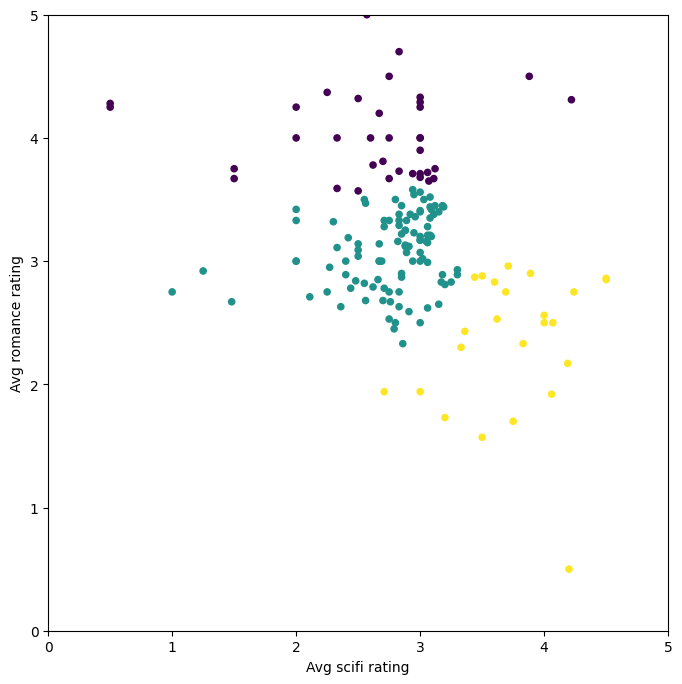

In [ ]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

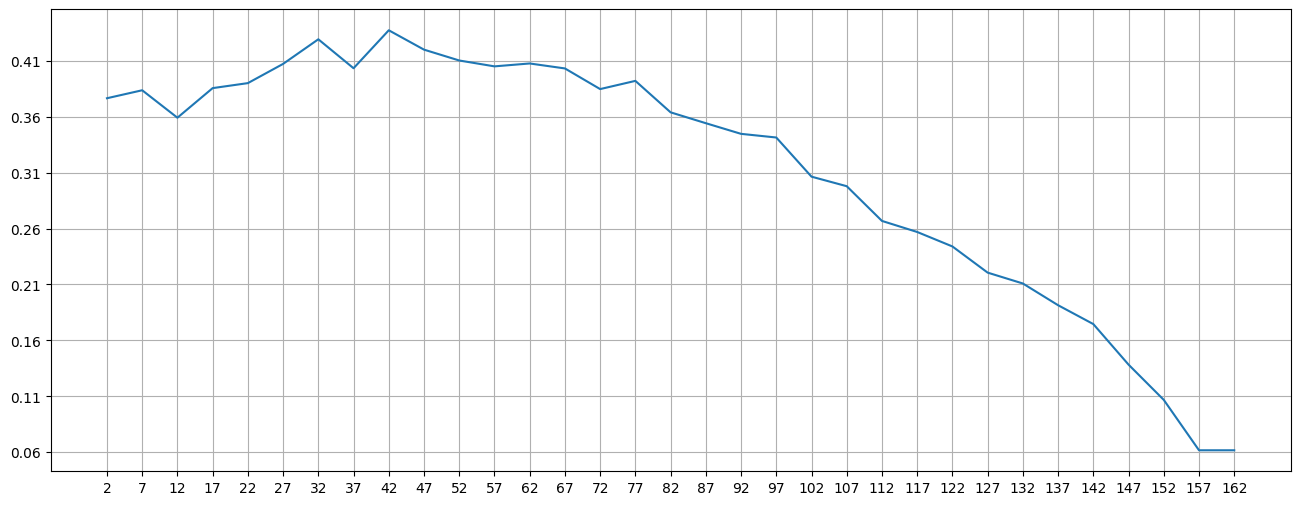

In [ ]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


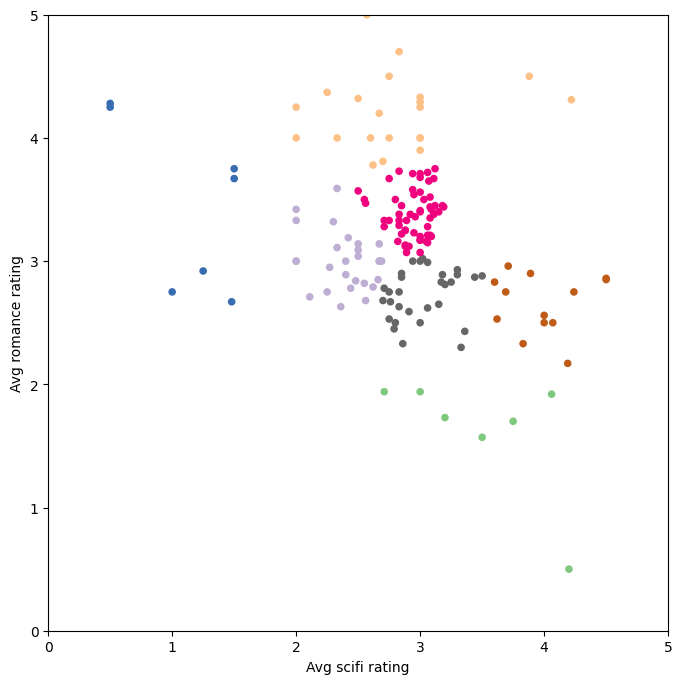

In [ ]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [ ]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


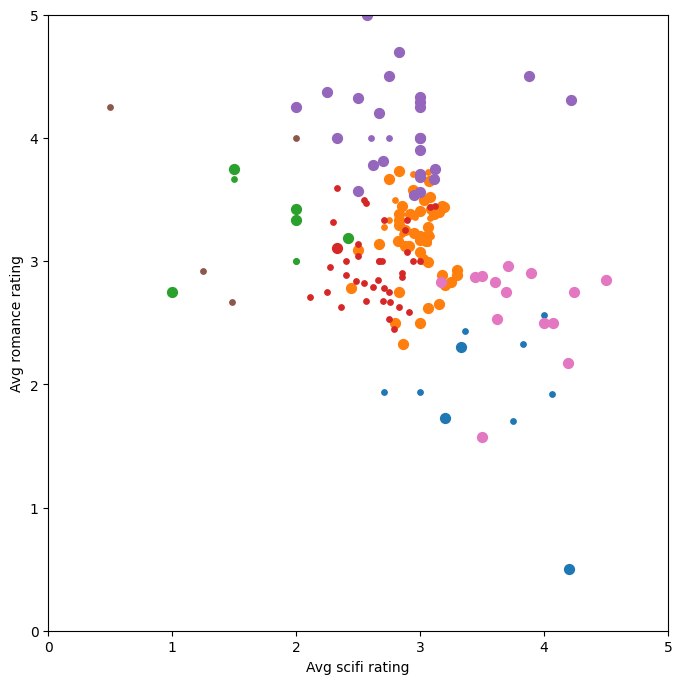

In [ ]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

In [ ]:
# CODE

### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [ ]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

# Define function to get the user who rate a movie the most
def get_users_who_rate_the_most(most_rated_movies, n_users):
    most_rated_movies['num_ratings'] = - most_rated_movies.isnull().sum(axis=1)
    most_rated_movies = most_rated_movies.sort_values(by=['num_ratings'], ascending=False)
    most_rated_movies = most_rated_movies.iloc[:n_users, :]
    most_rated_movies = most_rated_movies.drop('num_ratings', axis=1)
    return most_rated_movies

# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
# print(most_rated_movies_users_selection)
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())

dataset dimensions:  (18, 30)
title  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
479                    5.0                               5.0   
473                    3.0                               5.0   
67                     3.5                               3.0   
413                    5.0                               5.0   
589                    5.0                               4.5   

title  Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
479                    4.0                               4.5   
473                    4.0                               4.5   
67                     2.0                               3.5   
413                    5.0                               4.0   
589                    4.5                               3.5   

title  Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
479                   5.0                                        4.5   
473                   4.5                               

<ipython-input-17-0b2c7ceec495>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


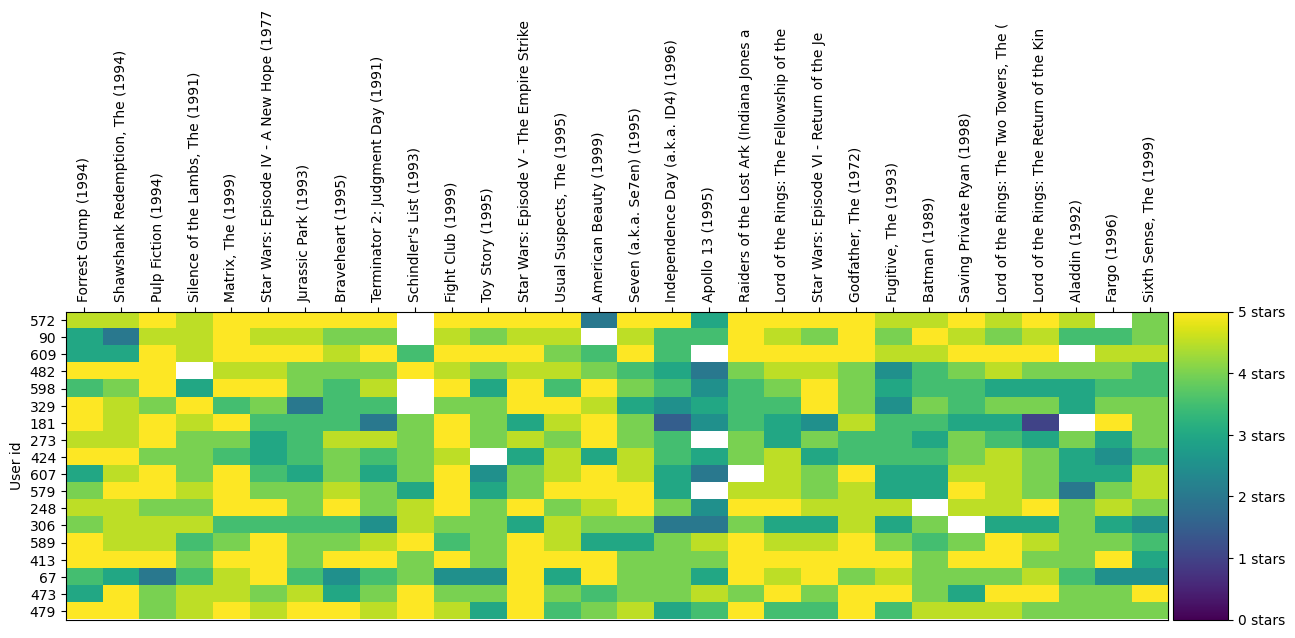

In [ ]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [ ]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

<ipython-input-17-0b2c7ceec495>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


In [ ]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [ ]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)
# Select the mas number of users and movies heatmap cluster
# Cluster and print some of them
clustered = pd.concat([get_most_rated_movies(user_movie_ratings, 1000).reset_index(), pd.DataFrame({'group':predictions})], axis=1)
# draw_movie_clusters(clustered, max_users, max_movies)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
<ipython-input-17-0b2c7ceec495>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


### Predictions and Recommendation

<ipython-input-17-0b2c7ceec495>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


     Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
15                   3.5                               4.0   
16                   5.0                               5.0   
21                   5.0                               5.0   
22                   NaN                               NaN   
40                   2.0                               NaN   
..                   ...                               ...   
541                  5.0                               5.0   
552                  NaN                               NaN   
580                  4.5                               5.0   
584                  NaN                               NaN   
592                  4.0                               4.5   

     Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
15                   3.0                               3.0   
16                   5.0                               4.5   
21                   NaN                               NaN   
22     

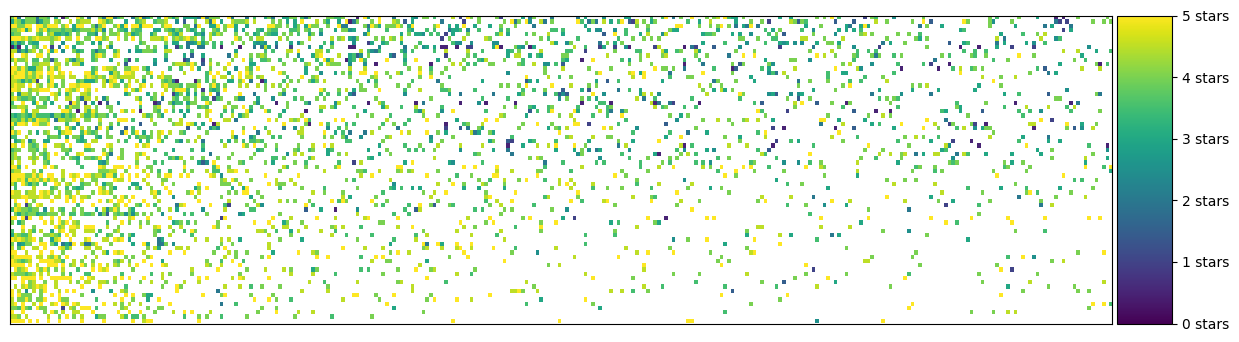

In [ ]:
# Pick a cluster ID from the clusters above
cluster_number = 11
# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
print(cluster)
# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [ ]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

4.009615384615385

In [ ]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Fight Club (1999)                                            4.327869
Pulp Fiction (1994)                                          4.446429
Matrix, The (1999)                                           4.009615
Shawshank Redemption, The (1994)                             4.460784
American Beauty (1999)                                       3.968750
Silence of the Lambs, The (1991)                             4.163043
Memento (2000)                                               4.166667
Forrest Gump (1994)                                          4.162791
American History X (1998)                                    4.348837
Eternal Sunshine of the Spotless Mind (2004)                 4.268293
Seven (a.k.a. Se7en) (1995)                                  4.269231
Godfather, The (1972)                                        4.230769
Usual Suspects, The (1995)                                   4.243590
Schindler's List (1993)                                      4.283784
Inception (2010)    

In [ ]:
cluster

,Fight Club (1999),Pulp Fiction (1994),"Matrix, The (1999)","Shawshank Redemption, The (1994)",American Beauty (1999),"Silence of the Lambs, The (1991)",Memento (2000),Forrest Gump (1994),American History X (1998),Eternal Sunshine of the Spotless Mind (2004),...,Coraline (2009),Panic Room (2002),Rounders (1998),"Curious Case of Benjamin Button, The (2008)","City of Lost Children, The (Cité des enfants perdus, La) (1995)","Birdcage, The (1996)","Patriot, The (2000)",True Romance (1993),Bridget Jones's Diary (2001),Jackie Brown (1997)
4,4.0,5.0,2.0,NaN,4.0,4.0,4.0,2.0,4.0,4.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
18,3.0,4.5,4.0,3.0,4.0,4.0,4.0,2.0,3.0,4.0,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0
35,5.0,5.0,4.0,4.0,5.0,5.0,NaN,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,4.0,4.0,4.5,5.0,3.0,4.5,NaN,5.0,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,3.5,4.0,4.0,NaN,NaN,NaN,NaN,4.0,3.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,4.5,5.0,NaN,5.0,NaN,NaN,4.5,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,3.5
58,4.0,4.0,3.5,5.0,4.0,3.5,NaN,5.0,4.0,4.0,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
57,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,4.5,4.5,4.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Predict for a specific user

# Pick a user ID from the dataset
user_id = 7
# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
# Which movies did they not rate?
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Heat (1995)                                                        4.562500
Shawshank Redemption, The (1994)                                   4.460784
Life Is Beautiful (La Vita è bella) (1997)                         4.411765
True Romance (1993)                                                4.400000
Green Mile, The (1999)                                             4.394737
American History X (1998)                                          4.348837
Casablanca (1942)                                                  4.333333
Fight Club (1999)                                                  4.327869
Inglourious Basterds (2009)                                        4.304348
City of Lost Children, The (Cité des enfants perdus, La) (1995)    4.300000
Schindler's List (1993)                                            4.283784
Blow (2001)                                                        4.277778
Star Wars: Episode VI - Return of the Jedi (1983)                  4.277778
Seven (a.k.a

## Using Collaborative Filtering (With fast.ai)

In [ ]:
! [ -e /content ] && pip install -Uqq fastai

In [ ]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [ ]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [ ]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [ ]:
dls.show_batch()

,user,title,rating
0,85,"Man Who Would Be King, The (1975)",3
1,406,Paris Is Burning (1990),5
2,332,Executive Decision (1996),4
3,363,Short Cuts (1993),2
4,102,Back to the Future (1985),4
5,87,Braveheart (1995),4
6,490,"English Patient, The (1996)",2
7,90,Jaws (1975),4
8,943,"Mask, The (1994)",2
9,43,"Rock, The (1996)",4


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.950101,0.934294,00:15
1,0.850896,0.871558,00:19
2,0.724783,0.826014,00:09
3,0.592962,0.813364,00:09
4,0.493715,0.814535,00:08


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [ ]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [ ]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [ ]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3310),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3147),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2938), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2568), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2564), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.2422), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2404), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2351), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2318), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2212), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2191), 'Speed 2: Cruise Control (1997)', 2.1315789473684212),
 (tensor(-0.2175), 'Tales from the Hood (1995)', 2.037037037037037),
 (tensor(-0.2163), 'Flintstones, The (1994)', 2.064516129032258),
 (tensor(-0.2148), 'Beverly Hills Ninja (1997)', 2.3125),
 (

Or the ones with the best bias:

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5614), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5587), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5269), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5202), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5126), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.4912), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4728), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4702), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4687), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4622), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4620), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4499), 'Raiders of the Lost Ark (1981)', 4.252380952380952),
 (tensor(0.4420), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4388), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4290), 'Casablanca (1942)', 4.45679012345679)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [ ]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1145), 'Wrong Trousers, The (1993)'),
 (tensor(1.0887), 'Godfather, The (1972)'),
 (tensor(1.0831), 'Casablanca (1942)'),
 (tensor(1.0765), 'Close Shave, A (1995)'),
 (tensor(1.0595), 'Chinatown (1974)'),
 (tensor(1.0512),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9900), 'Secrets & Lies (1996)'),
 (tensor(0.9837), "One Flew Over the Cuckoo's Nest (1975)"),
 (tensor(0.9817), 'Lawrence of Arabia (1962)'),
 (tensor(0.9796), 'Third Man, The (1949)')]

And the worst:

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2255), 'Jungle2Jungle (1997)'),
 (tensor(-1.1824), 'Leave It to Beaver (1997)'),
 (tensor(-1.1602), 'Grease 2 (1982)'),
 (tensor(-1.1537), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.1190), 'Speed 2: Cruise Control (1997)'),
 (tensor(-1.1086), "McHale's Navy (1997)"),
 (tensor(-1.1040), 'Jaws 3-D (1983)'),
 (tensor(-1.1012), 'Congo (1995)'),
 (tensor(-1.0843), 'That Darn Cat! (1997)'),
 (tensor(-1.0766), 'Children of the Corn: The Gathering (1996)')]

Same thing for our second dimension:

In [ ]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1179), 'Titanic (1997)'),
 (tensor(1.0445), 'Braveheart (1995)'),
 (tensor(1.0328), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9047), 'Field of Dreams (1989)'),
 (tensor(0.8544), 'Independence Day (ID4) (1996)'),
 (tensor(0.8027), "It's a Wonderful Life (1946)"),
 (tensor(0.7978), 'Fugitive, The (1993)'),
 (tensor(0.7825), 'American President, The (1995)'),
 (tensor(0.7824), 'Pretty Woman (1990)'),
 (tensor(0.7704), 'Return of the Jedi (1983)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9045), 'Keys to Tulsa (1997)'),
 (tensor(-0.8728), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8564), 'Clockwork Orange, A (1971)'),
 (tensor(-0.8560), 'Brazil (1985)'),
 (tensor(-0.8191), 'Serial Mom (1994)'),
 (tensor(-0.8013), 'Sweet Hereafter, The (1997)'),
 (tensor(-0.7490), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.7321), 'Cable Guy, The (1996)'),
 (tensor(-0.7260), 'Trainspotting (1996)'),
 (tensor(-0.7201), 'Very Brady Sequel, A (1996)')]

And we can even plot the movies according to their scores on those dimensions:

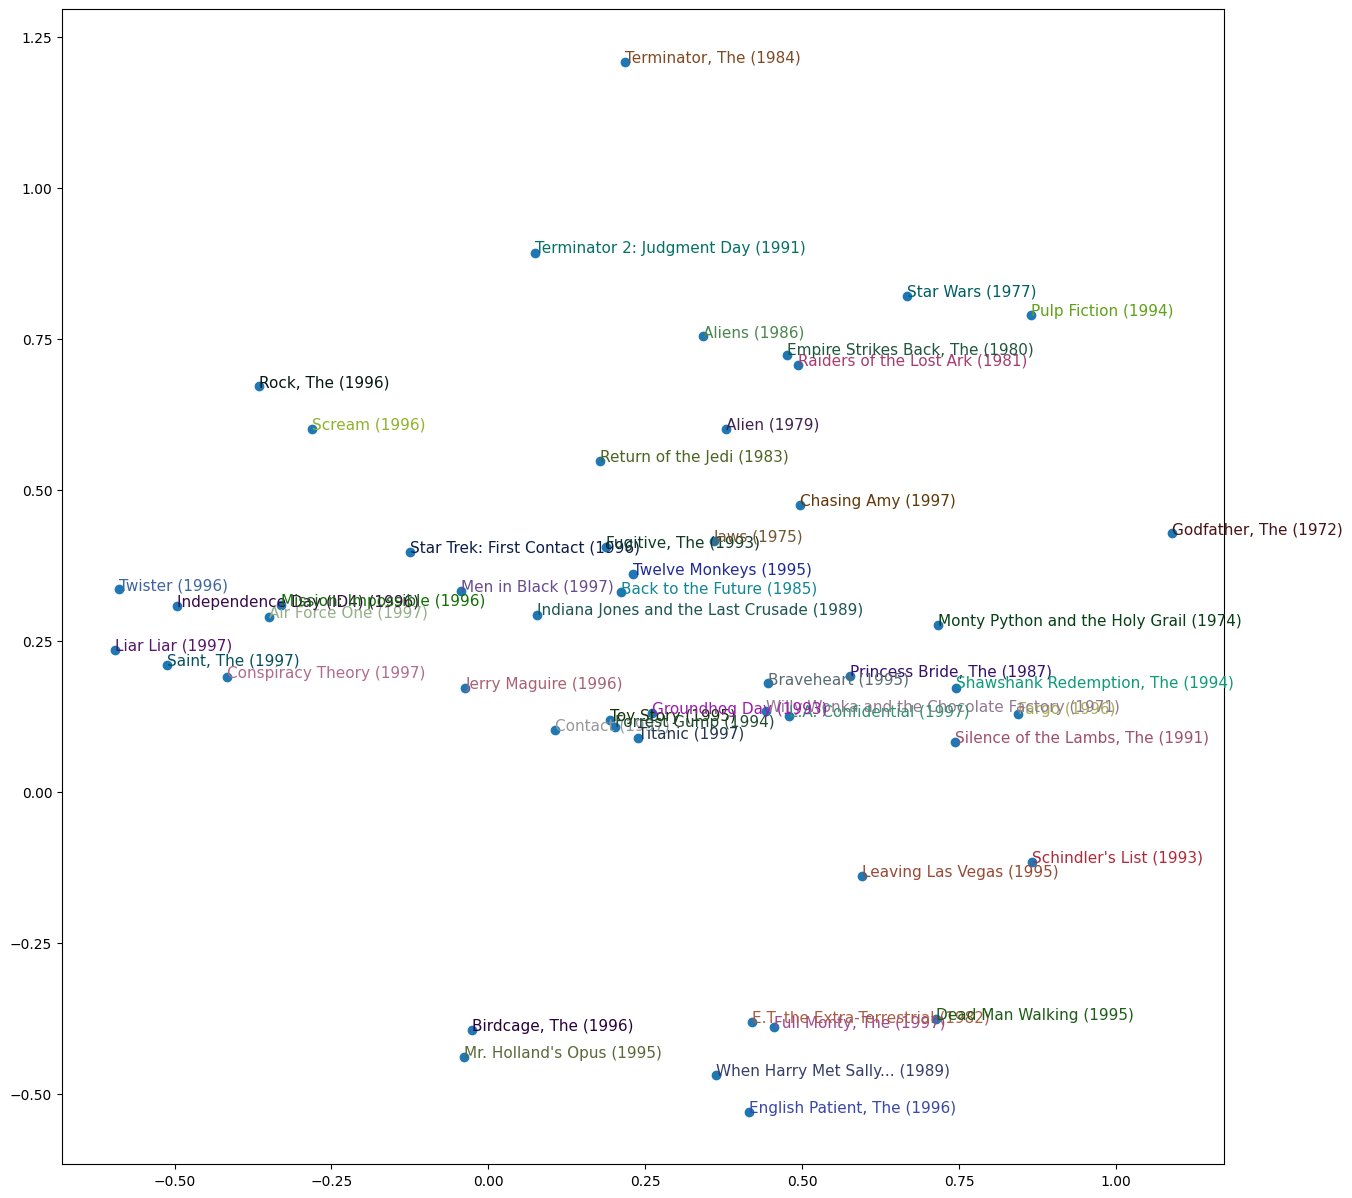

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [ ]:
pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163005 sha256=f8473f1b157e171ed6e6008f4c6700dc7f8f2478864d49e5b745b51378787344
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.matrix_factorization import SVD

# Load the MovieLens 100k dataset from Surprise package
data = Dataset.load_builtin('ml-100k')

# Define a parameter grid to search through
param_grid = {'n_factors': [50, 100, 150],  # Different values of n_factors
              'lr_all': [0.005, 0.01],       # Learning rate
              'reg_all': [0.02, 0.1]}        # Regularization term

# Iterate over the parameter grid
for n_factors in param_grid['n_factors']:
    for lr_all in param_grid['lr_all']:
        for reg_all in param_grid['reg_all']:
            # Initialize SVD with current parameter settings
            algo = SVD(n_factors=n_factors, lr_all=lr_all, reg_all=reg_all)

            # Perform cross-validation
            results = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

            # Compute and print the average RMSE score
            avg_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
            print(f'n_factors={n_factors}, lr_all={lr_all}, reg_all={reg_all}, RMSE={avg_rmse:.4f}')


Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
n_factors=50, lr_all=0.005, reg_all=0.02, RMSE=0.9421
n_factors=50, lr_all=0.005, reg_all=0.1, RMSE=0.9434
n_factors=50, lr_all=0.01, reg_all=0.02, RMSE=0.9610
n_factors=50, lr_all=0.01, reg_all=0.1, RMSE=0.9317
n_factors=100, lr_all=0.005, reg_all=0.02, RMSE=0.9461
n_factors=100, lr_all=0.005, reg_all=0.1, RMSE=0.9420
n_factors=100, lr_all=0.01, reg_all=0.02, RMSE=0.9629
n_factors=100, lr_all=0.01, reg_all=0.1, RMSE=0.9275
n_factors=150, lr_all=0.005, reg_all=0.02, RMSE=0.9476
n_factors=150, lr_all=0.005, reg_all=0.1, RMSE=0.9411
n_factors=150, lr_all=0.01, reg_all=0.02, RMSE=0.9628
n_factors=150, lr_all=0.01, reg_all=0.1, RMSE=0.9260


In this experiment:

1. We load the MovieLens 100k dataset and split it into training and test sets.
2. We define a parameter grid containing different values for `n_factors`, `n_epochs`, `lr_all`, and `reg_all`.
3. We iterate over the parameter grid and train an SVD model with the specified parameters on the training set.
4. We measure the training time and evaluate the model's performance on the test set using RMSE (Root Mean Squared Error).
5. Finally, we print the parameter settings, RMSE, and training time for each combination of parameters.

By analyzing the results, we can identify whether any specific parameters have a significant impact on the speed of convergence or the performance of the model. This information can help us select optimal parameter values for collaborative filtering models based on our specific requirements.